# Instagram Users EDA and 2025 prediction

## Import Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arpitsinghaiml/instagram-user-growth-by-country")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arpitsinghaiml/instagram-user-growth-by-country/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/arpitsinghaiml/instagram-user-growth-by-country/versions/1

instagram-users-by-country-2024.csv


## Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score

## Load Dataset

In [4]:
df = pd.read_csv(path + "/instagram-users-by-country-2024.csv")

In [5]:
df.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023
0,India,392465000.0,33.1,66.9,229600000
1,United States,172606200.0,55.4,44.6,143400000
2,Indonesia,90183200.0,54.2,45.8,89150000
3,Pakistan,18593301.0,35.1,64.9,12950000
4,Nigeria,12635900.0,46.5,53.5,7100000


In [6]:
df['country'].count()

226

In [7]:
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Other"


df['continent'] = df['country'].apply(country_to_continent)
df.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023,continent
0,India,392465000.0,33.1,66.9,229600000,Asia
1,United States,172606200.0,55.4,44.6,143400000,North America
2,Indonesia,90183200.0,54.2,45.8,89150000,Asia
3,Pakistan,18593301.0,35.1,64.9,12950000,Asia
4,Nigeria,12635900.0,46.5,53.5,7100000,Africa


# EDA

## Intagram Users Growth by Continent

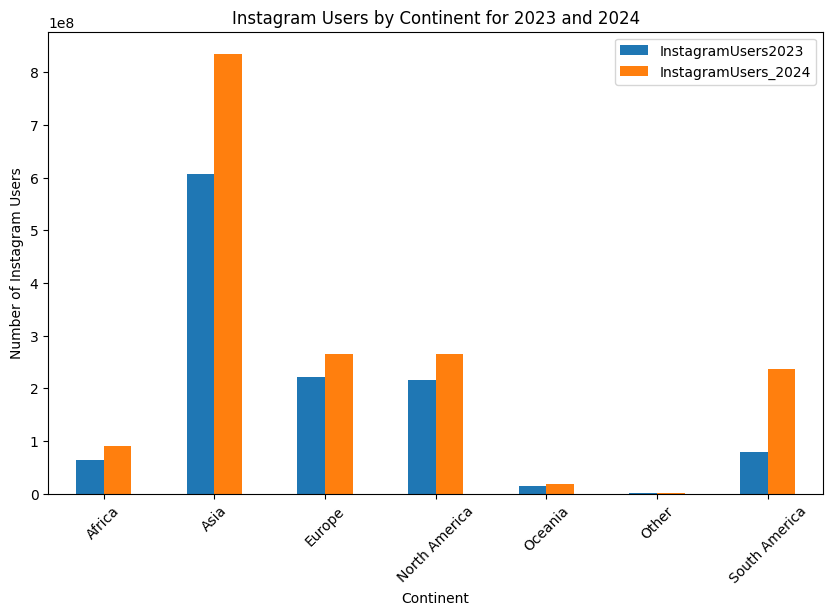

In [8]:
# Group by continent and sum the Instagram users for 2023 and 2024
df_grouped = df.groupby('continent')[['InstagramUsers2023', 'InstagramUsers_2024']].sum().reset_index()

# Plot the data
df_grouped.plot(x='continent', kind='bar', figsize=(10, 6))
plt.title('Instagram Users by Continent for 2023 and 2024')
plt.xlabel('Continent')
plt.ylabel('Number of Instagram Users')
plt.xticks(rotation=45)
plt.legend(['InstagramUsers2023', 'InstagramUsers_2024'])
plt.show()

## Average Growth by Continent

In [9]:
# Calculate the growth in Instagram users from 2023 to 2024
df_grouped['Growth_Avg'] = (df_grouped['InstagramUsers_2024'] / df_grouped['InstagramUsers2023']) - 1

df_grouped[['continent', 'Growth_Avg']].sort_values('Growth_Avg', ascending=False)

,continent,Growth_Avg
6,South America,2.018930
0,Africa,0.409719
1,Asia,0.376467
3,North America,0.232357
4,Oceania,0.220935
2,Europe,0.193205
5,Other,0.075141


## Instagram Users Sex by Continent

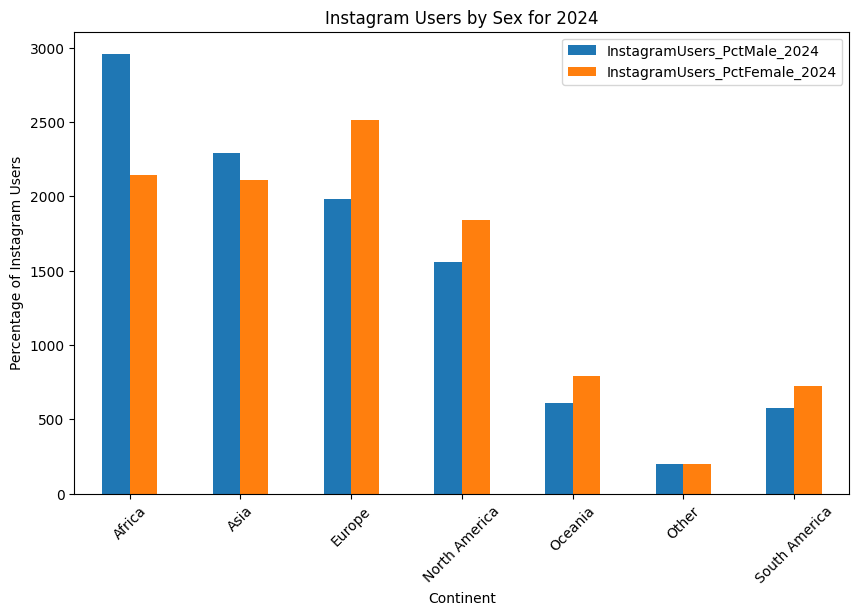

In [10]:
# Group by continent and sum the Instagram users for 2023 and 2024
df_grouped_sex = df.groupby('continent')[['InstagramUsers_PctMale_2024', 'InstagramUsers_PctFemale_2024']].sum().reset_index()

# Plot the data
df_grouped_sex.plot(x='continent', kind='bar', figsize=(10, 6))
plt.title('Instagram Users by Sex for 2024')
plt.xlabel('Continent')
plt.ylabel('Percentage of Instagram Users')
plt.xticks(rotation=45)
plt.legend(['InstagramUsers_PctMale_2024', 'InstagramUsers_PctFemale_2024'])
plt.show()

# Model

## Data Normalization

In [ ]:
nan_counts = df.isna().sum()
print(nan_counts)
df.dropna(inplace=True)

country                           0
InstagramUsers_2024              21
InstagramUsers_PctFemale_2024    21
InstagramUsers_PctMale_2024      21
InstagramUsers2023                0
continent                         0
dtype: int64


### Defining Growth Average

In [ ]:
df['Growth_Avg'] = (df['InstagramUsers_2024'] / df['InstagramUsers2023']) - 1
# Normalize Growth_Avg if it is too large
max_growth_threshold = 2.018930  # Define a threshold for maximum growth
df['Growth_Avg'] = df['Growth_Avg'].apply(lambda x: min(x, max_growth_threshold))


## Expected Growth 

In [ ]:
df['Expected_InstagramUsers_2025'] = df['InstagramUsers_2024'] * (1 + df['Growth_Avg'])

## Splitting X_train and X_test

In [ ]:
# Define the features and target variable
X = df.drop(columns=['Expected_InstagramUsers_2025', 'country', 'continent', 'Growth_Avg'])
y = df['Expected_InstagramUsers_2025']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (162, 5)
Test set size: (41, 5)


## Creating Model

In [ ]:
# Define the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)

# Train the model
xgb_reg.fit(X_train, y_train)

# Predict the target variable for the test data
y_pred_xgb = xgb_reg.predict(X_test)

R2 score: 0.9989838578131086


### R2 Scoring

In [45]:
# Calculate the R2 score
r2_xgb = r2_score(y_test, y_pred_xgb)
print("R2 score:", r2_xgb)

R2 score: 0.9989838578131086


### Predicting all the Dataset

In [39]:
y_pred_all = xgb_reg.predict(X)

df['predicted_InstagramUsers_2025'] = y_pred_all

### Plotting

#### Plotting Expected versus Predicted

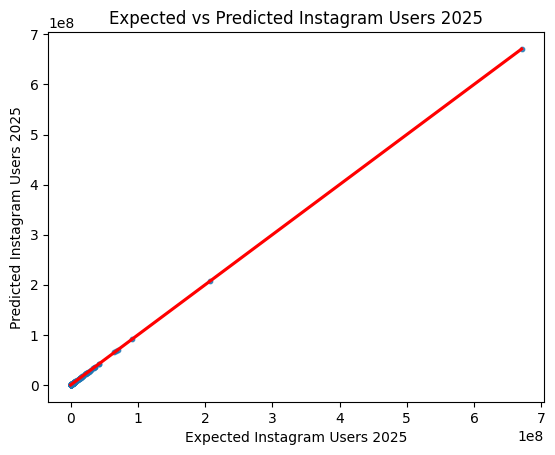

In [40]:
# Create a scatter plot with a regression line
sns.regplot(x=df['Expected_InstagramUsers_2025'], y=df['predicted_InstagramUsers_2025'], scatter_kws={'s':10}, line_kws={'color':'red'})
plt.xlabel('Expected Instagram Users 2025')
plt.ylabel('Predicted Instagram Users 2025')
plt.title('Expected vs Predicted Instagram Users 2025')
plt.show()

#### Plotting Instagram Users 2023, Instagram Users 2024, Expected Instagram Users 2025 and Predicted Instagram Users 2025

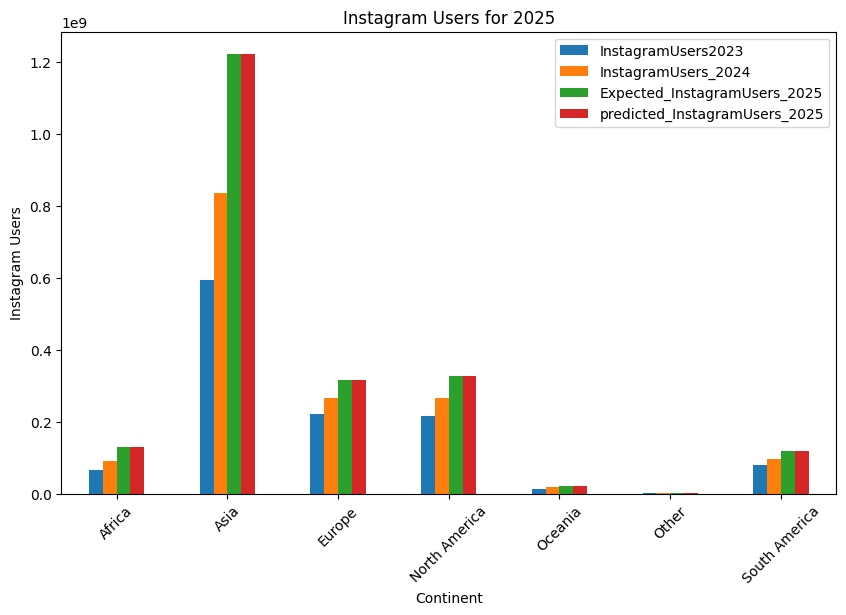

In [41]:
# Group by continent and sum the Instagram users for 2023 and 2024
df_grouped_exp = df.groupby('continent')[['InstagramUsers2023' ,'InstagramUsers_2024', 'Expected_InstagramUsers_2025', 'predicted_InstagramUsers_2025']].sum().reset_index()

# Plot the data
df_grouped_exp.plot(x='continent', kind='bar', figsize=(10, 6))
plt.title('Instagram Users for 2025')
plt.xlabel('Continent')
plt.ylabel('Instagram Users')
plt.xticks(rotation=45)
plt.legend(['InstagramUsers2023', 'InstagramUsers_2024', 'Expected_InstagramUsers_2025', 'predicted_InstagramUsers_2025'])
plt.show()

#### Checking difference between Expected and Predicted

In [43]:
df['diff_2025'] = df['Expected_InstagramUsers_2025'] - df['predicted_InstagramUsers_2025']
df['diff_pct_2025'] = (df['Expected_InstagramUsers_2025'] - df['predicted_InstagramUsers_2025']) / df['Expected_InstagramUsers_2025']

In [44]:
df.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023,continent,Growth_Avg,Expected_InstagramUsers_2025,predicted_InstagramUsers_2025,diff_2025,diff_pct_2025
0,India,"392,465,000.00",33.10,66.90,229600000,Asia,0.71,"670,857,039.31","670,855,808.00","1,231.31",0.00
1,United States,"172,606,200.00",55.40,44.60,143400000,North America,0.20,"207,760,810.87","207,760,608.00",202.87,0.00
2,Indonesia,"90,183,200.00",54.20,45.80,89150000,Asia,0.01,"91,228,374.23","91,228,328.00",46.23,0.00
3,Pakistan,"18,593,301.00",35.10,64.90,12950000,Asia,0.44,"26,695,817.92","26,695,818.00",-0.08,-0.00
4,Nigeria,"12,635,900.00",46.50,53.50,7100000,Africa,0.78,"22,488,164.62","22,488,174.00",-9.38,-0.00
